In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
df = pd.read_csv("/content/query.csv")

print("=== Preview Data ===")
print(df.head())

print("\n=== Info Data ===")
print(df.info())

print("\n=== Missing Value ===")
print(df.isnull().sum())

=== Preview Data ===
                       time  latitude  longitude    depth  mag magType   nst  \
0  2022-10-28T23:27:49.843Z   36.8950   127.8467    9.469  3.2      mb  14.0   
1  2023-01-08T16:28:15.482Z   37.7593   126.2251   16.663  3.6      ml   8.0   
2  2023-01-11T03:19:44.834Z   35.4541   139.2024   24.182  3.8     mwr  18.0   
3  2025-05-11T22:57:20.168Z   31.6492   138.1785  378.015  3.8      mb  34.0   
4  2023-11-29T19:55:24.597Z   35.7301   129.3778   10.000  3.8      ml  13.0   

   gap   dmin   rms  ...                   updated  \
0   79  0.547  0.37  ...  2023-02-20T11:53:00.505Z   
1  242  0.424  0.56  ...  2023-03-20T06:03:00.040Z   
2  128  1.140  0.46  ...  2023-03-20T06:03:18.040Z   
3   89  2.013  0.72  ...  2025-07-24T21:30:09.040Z   
4  112  1.200  0.82  ...  2024-02-06T21:53:52.040Z   

                                   place        type horizontalError  \
0                            South Korea  earthquake            2.23   
1                            

In [ ]:
if 'nst' in df.columns:
    df['nst'] = df['nst'].fillna(df['nst'].median())
if 'place' in df.columns:
    df['place'] = df['place'].fillna("Unknown")

In [ ]:
# Fitur dasar
num_cols = ['latitude', 'longitude', 'depth', 'mag']
df_clean = df[num_cols].copy()

# Tangani NA pada fitur utama
df_clean = df_clean.fillna(df_clean.mean(numeric_only=True))

# Feature engineering:
# - log depth (mengurangi skew)
# - interaksi magnitude * depth
# - sin/cos untuk latitude & longitude (menangani sifat sirkular koordinat)
lat_rad = np.radians(df_clean['latitude'].clip(-90, 90))
lon_rad = np.radians(df_clean['longitude'].clip(-180, 180))

df_feat = pd.DataFrame({
    'lat': df_clean['latitude'],
    'lon': df_clean['longitude'],
    'depth': df_clean['depth'].clip(lower=0),
    'mag': df_clean['mag'].clip(lower=0),
    'depth_log': np.log1p(df_clean['depth'].clip(lower=0)),
    'mag_depth': df_clean['mag'] * df_clean['depth'].clip(lower=0),
    'sin_lat': np.sin(lat_rad),
    'cos_lat': np.cos(lat_rad),
    'sin_lon': np.sin(lon_rad),
    'cos_lon': np.cos(lon_rad),
})

In [ ]:
scaler = RobustScaler()                 # lebih robust terhadap outlier daripada StandardScaler
X_scaled = scaler.fit_transform(df_feat)

# PCA: ambil komponen secukupnya untuk menjelaskan ≥95% variasi
pca_full = PCA(n_components=None, random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_comp = int(np.searchsorted(cum_var, 0.95) + 1)  # jumlah komponen minimal utk >=95%
pca = PCA(n_components=n_comp, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"\n=== PCA ===")
print(f"Total komponen: {X_scaled.shape[1]}, dipakai: {n_comp}, Variansi terserap ≈ {cum_var[n_comp-1]:.3f}")


=== PCA ===
Total komponen: 10, dipakai: 3, Variansi terserap ≈ 0.954



=== K-Means (Auto-k) ===
k optimal (silhouette max): 3
Silhouette: 0.6002
Davies–Bouldin: 0.5201


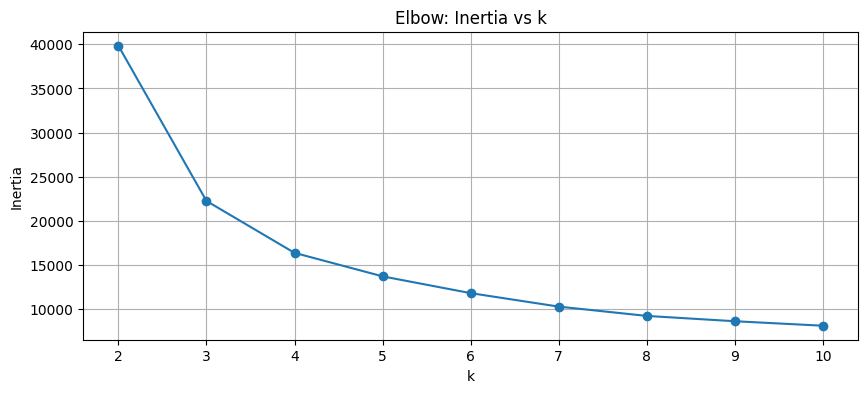

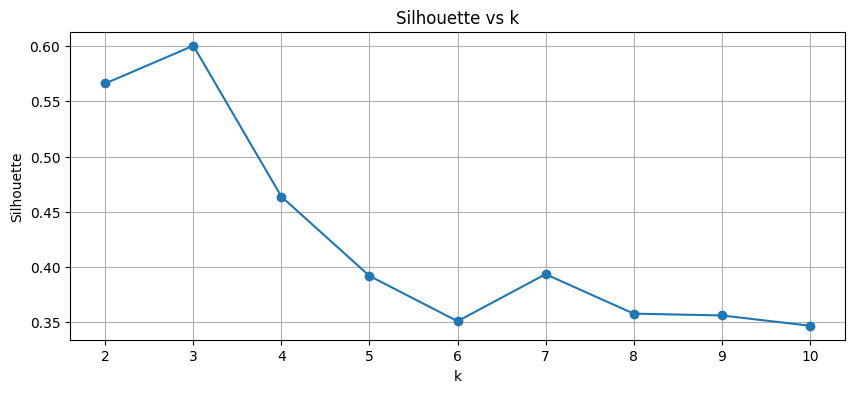

In [ ]:
k_range = range(2, 11)
best_sil_kmeans = -1
best_k = None
best_labels_kmeans = None
best_kmeans_model = None

inertias = []
sil_scores = []
dbi_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, n_init=20, max_iter=600, random_state=42)
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    dbi = davies_bouldin_score(X_pca, labels)

    inertias.append(km.inertia_)
    sil_scores.append(sil)
    dbi_scores.append(dbi)

    if sil > best_sil_kmeans:
        best_sil_kmeans = sil
        best_k = k
        best_labels_kmeans = labels
        best_kmeans_model = km

# ringkasan hasil terbaik
dbi_kmeans = davies_bouldin_score(X_pca, best_labels_kmeans)
print("\n=== K-Means (Auto-k) ===")
print(f"k optimal (silhouette max): {best_k}")
print(f"Silhouette: {best_sil_kmeans:.4f}")
print(f"Davies–Bouldin: {dbi_kmeans:.4f}")

# plot elbow (inertia)
plt.figure(figsize=(10,4))
plt.plot(list(k_range), inertias, marker='o')
plt.title('Elbow: Inertia vs k')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.grid(True)
plt.show()

# plot silhouette vs k
plt.figure(figsize=(10,4))
plt.plot(list(k_range), sil_scores, marker='o')
plt.title('Silhouette vs k')
plt.xlabel('k'); plt.ylabel('Silhouette'); plt.grid(True)
plt.show()

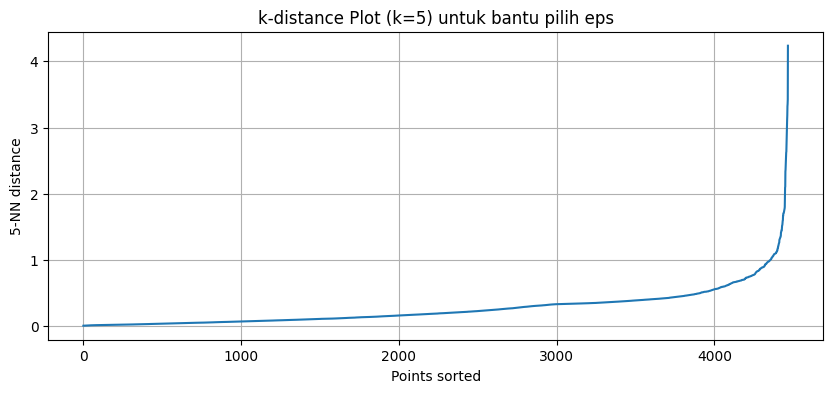


=== DBSCAN (Grid Search) ===
eps=2.0, min_samples=3
Clusters: 2, Noise: 7
Silhouette: 0.5085, Davies–Bouldin: 1.0788


In [ ]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)
k_dists = np.sort(distances[:, -1])

plt.figure(figsize=(10,4))
plt.plot(k_dists)
plt.title('k-distance Plot (k=5) untuk bantu pilih eps')
plt.xlabel('Points sorted'); plt.ylabel('5-NN distance'); plt.grid(True)
plt.show()

eps_grid = [0.5, 1, 2, 3, 5]
min_samples_grid = [3, 5, 8]

best_eps, best_min_samples = None, None
best_sil_db, best_dbi_db = -1, np.nan
best_labels_db, best_noise, best_nclusters_db = None, 0, 0

for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=float(eps), min_samples=int(ms)).fit(X_pca)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()

        if n_clusters > 1:
            sil = silhouette_score(X_pca, labels)
            dbi = davies_bouldin_score(X_pca, labels)
            if sil > best_sil_db:
                best_sil_db = sil
                best_dbi_db = dbi
                best_eps, best_min_samples = float(eps), int(ms)
                best_labels_db = labels
                best_noise = int(n_noise)
                best_nclusters_db = int(n_clusters)

print("\n=== DBSCAN (Grid Search) ===")
if best_labels_db is not None:
    print(f"eps={best_eps}, min_samples={best_min_samples}")
    print(f"Clusters: {best_nclusters_db}, Noise: {best_noise}")
    print(f"Silhouette: {best_sil_db:.4f}, Davies–Bouldin: {best_dbi_db:.4f}")
else:
    print("Tidak ditemukan kombinasi DBSCAN dengan >=2 cluster yang valid.")
    best_sil_db = np.nan
    best_dbi_db = np.nan
    best_nclusters_db = 0
    best_noise = (len(X_pca) if len(X_pca) else 0)

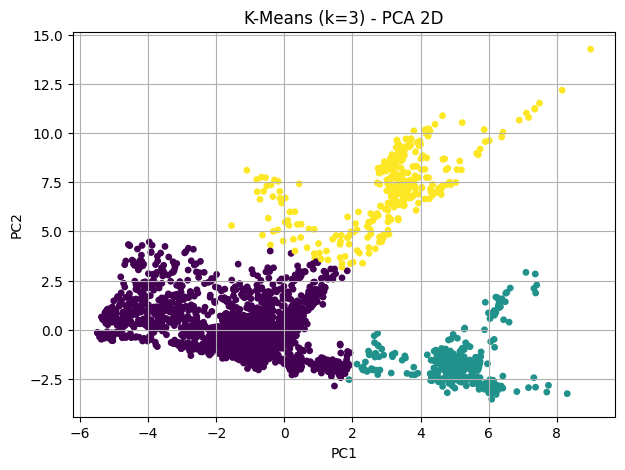

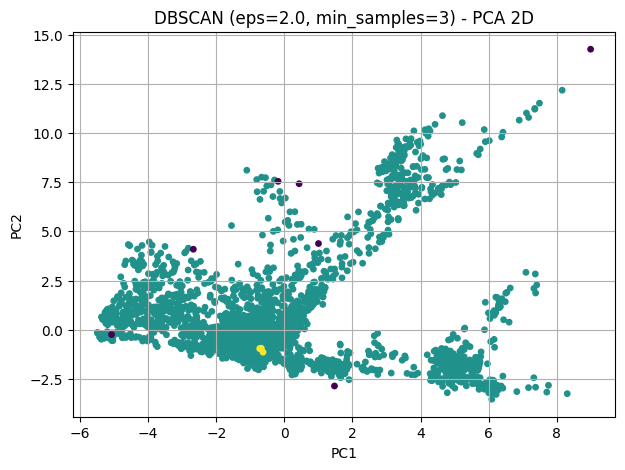

In [ ]:
viz_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(viz_pca[:,0], viz_pca[:,1], c=best_labels_kmeans, s=15)
plt.title(f'K-Means (k={best_k}) - PCA 2D')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.grid(True)
plt.show()

if best_labels_db is not None:
    plt.figure(figsize=(7,5))
    plt.scatter(viz_pca[:,0], viz_pca[:,1], c=best_labels_db, s=15)
    plt.title(f'DBSCAN (eps={best_eps}, min_samples={best_min_samples}) - PCA 2D')
    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.grid(True)
    plt.show()

In [ ]:
summary = pd.DataFrame({
    'Model': ['K-Means', 'DBSCAN'],
    'Jumlah Cluster': [best_k, best_nclusters_db],
    'Silhouette Score': [best_sil_kmeans, best_sil_db],
    'Davies–Bouldin Index': [dbi_kmeans, best_dbi_db],
    'Noise Points (DBSCAN)': [0, best_noise]
})
print("\n=== Perbandingan K-Means vs DBSCAN ===")
print(summary)


=== Perbandingan K-Means vs DBSCAN ===
     Model  Jumlah Cluster  Silhouette Score  Davies–Bouldin Index  \
0  K-Means               3          0.600220              0.520148   
1   DBSCAN               2          0.508468              1.078813   

   Noise Points (DBSCAN)  
0                      0  
1                      7  
